<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_22/blob/main/kmeans_deep_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How it differs from the default solution? 

Here we are using a neural network instead of a logreg

# Load data & default imports

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import scipy.stats as sstats
import multiprocessing as mp
from sklearn import datasets
import sklearn.linear_model
from tqdm.auto import tqdm
from matplotlib import animation, pyplot, rc
import matplotlib.pyplot as plt
import httpimport
from os.path import join
import os.path
from PIL import Image
import tensorflow as tf

from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy as np

from sklearn.feature_extraction import image
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LogisticRegression

from FeaturesExtractor import FeaturesExtractor
from helpers import plot_history

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten

!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz

with np.load('cifar.npz') as data:
    X_trn = data['train_data']
    y_trn = data['train_labels']
    X_tst = data['test_data']
    y_tst = data['test_labels']

# testing

In [16]:
C          = -1
PATCH_SIZE = 8
PATCH_NUM  = 4000000
STRIDE     = 6
K          = 512

In [17]:
extractor = FeaturesExtractor(PATCH_SIZE, PATCH_NUM, STRIDE, K)

kmeans_counts = extractor.fit(X_trn)

X_trn_features = extractor.extract(X_trn)
X_tst_features = extractor.extract(X_tst)

y_trn_categorical = keras.utils.to_categorical(y_trn)
y_tst_categorical = keras.utils.to_categorical(y_tst)

Started fitting extractor:


  0%|          | 0/6401 [00:00<?, ?it/s]

Started extracting


  0%|          | 0/50000 [00:00<?, ?it/s]

Started extracting


  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
kmeans_counts

array([ 5951,  8316,  6255, 14379, 11945,  7542,  9640, 10715,  2663,
        4812,  9375,  5754,  5121,  8470,  8094, 10542, 10712,  6986,
        7225,  7897,  8463,  7220,  8980,  6205,  6900,  3231,  8737,
        3327,  6692,  4443, 35175,  9580, 10100, 12464,  5326, 13104,
        8227,  8162,  8702,  9820,  6923, 18468,  9948,  9341,  8187,
        6035,  5154,  4603,  7597,  7306,  9732,  3920,  5963,  9938,
       17432,  9476, 10748, 11714,  6546,  8464,  9363,  6132,  7153,
        8530,  5280,  7494,  6712,  8693,  8774,  7124,  5202, 13400,
        2956,  6365,  4683,  4771,  5346,  9163, 11417,  6474,  5389,
        4133,  2858,  8449,  7664,  6504,  9141,  4566, 12175, 24403,
       12143,  5423,  5380, 12924,  6735,  9854, 10069,  9861, 10195,
        7180,  6382,  7902,  3424,  9650,  7399, 11427,  6277,  5928,
        6826,  4365,  6443,  8854,  4086,  5191,  5468,  5655,  5641,
        5194,  5755,  5322,  7491,  5356, 13875,  4864, 10492,  8703,
        3754, 14768,

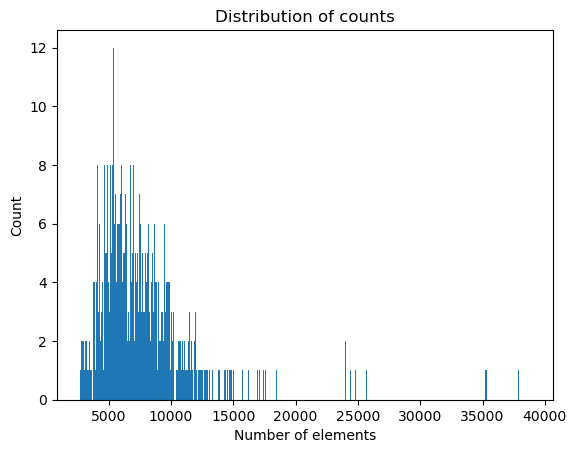

In [19]:
plt.hist(kmeans_counts, bins=K)
plt.xlabel('Number of elements')
plt.ylabel('Count')
plt.title('Distribution of counts')
plt.show()

Epoch 1/15
250/250 [==============================] - 2s 7ms/step - loss: 1.6811 - accuracy: 0.4005 - val_loss: 1.4882 - val_accuracy: 0.4681
Epoch 2/15
250/250 [==============================] - 2s 7ms/step - loss: 1.4532 - accuracy: 0.4832 - val_loss: 1.3929 - val_accuracy: 0.5057
Epoch 3/15
250/250 [==============================] - 2s 7ms/step - loss: 1.3522 - accuracy: 0.5209 - val_loss: 1.3421 - val_accuracy: 0.5216
Epoch 4/15
250/250 [==============================] - 2s 7ms/step - loss: 1.2801 - accuracy: 0.5458 - val_loss: 1.3290 - val_accuracy: 0.5302
Epoch 5/15
250/250 [==============================] - 2s 7ms/step - loss: 1.2116 - accuracy: 0.5675 - val_loss: 1.3188 - val_accuracy: 0.5296
Epoch 6/15
250/250 [==============================] - 2s 7ms/step - loss: 1.1553 - accuracy: 0.5902 - val_loss: 1.2973 - val_accuracy: 0.5465
Epoch 7/15
250/250 [==============================] - 2s 7ms/step - loss: 1.0984 - accuracy: 0.6067 - val_loss: 1.3058 - val_accuracy: 0.5506
Epoch 

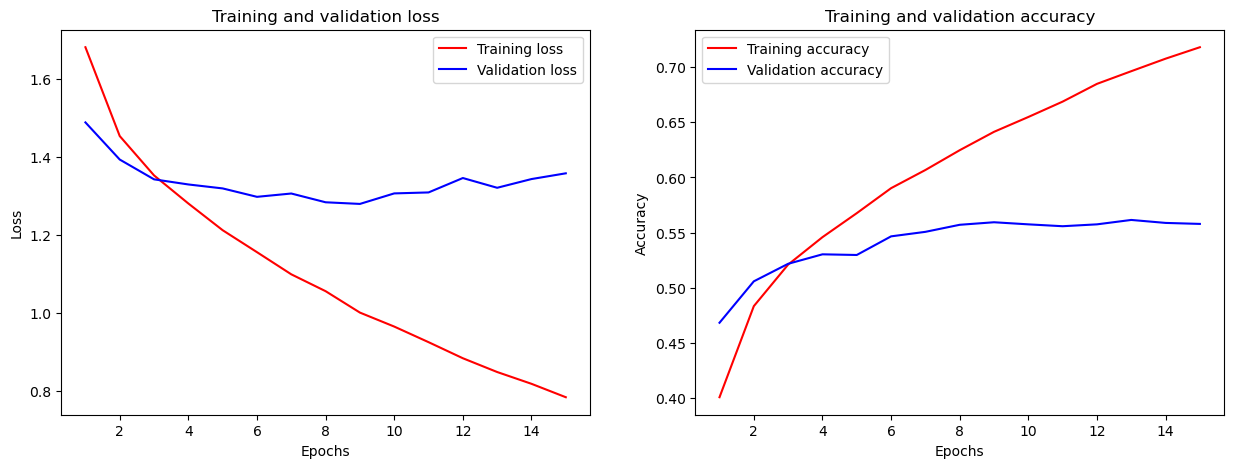

In [28]:
tf.keras.utils.set_random_seed(69)

M = X_trn_features.shape[1]
DROPOUT = 0.18

model = Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(M,)),
    keras.layers.Dropout(DROPOUT),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(DROPOUT),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(DROPOUT),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_trn_features, y_trn_categorical, batch_size=200, epochs=150, verbose=1, validation_data=(X_tst_features, y_tst_categorical))

loss, accuracy = model.evaluate(X_tst_features, y_tst_categorical, verbose=0)
print('Accuracy:', accuracy)
plot_history(history)

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier(
    n_estimators = 220,
    num_class = 10,
    max_depth = 10,
    seed = 69,
    eval_metric = 'merror'
)

model.fit(X_trn_features, y_trn, verbose = True, eval_set = [(X_tst_features, y_tst)])

# Save the model's weights
model.save_model('xgboost_220_10_new_patches.bin')

accuracy = model.score(X_tst_features, y_tst)

print('Accuracy:', accuracy)


[0]	validation_0-merror:0.62890
[1]	validation_0-merror:0.59420
[2]	validation_0-merror:0.57200


In [ ]:
"""
[0]	validation_0-merror:0.63950
[1]	validation_0-merror:0.59930
[2]	validation_0-merror:0.57680
[3]	validation_0-merror:0.55780
[4]	validation_0-merror:0.54220
[5]	validation_0-merror:0.53490
[6]	validation_0-merror:0.52710
[7]	validation_0-merror:0.52420
[8]	validation_0-merror:0.51860
[9]	validation_0-merror:0.51290
[10]	validation_0-merror:0.50550
[11]	validation_0-merror:0.49900
[12]	validation_0-merror:0.49650
[13]	validation_0-merror:0.49450
[14]	validation_0-merror:0.49320
[15]	validation_0-merror:0.48780
[16]	validation_0-merror:0.48520
[17]	validation_0-merror:0.48320
[18]	validation_0-merror:0.48050
[19]	validation_0-merror:0.47830
[20]	validation_0-merror:0.47910
[21]	validation_0-merror:0.47420
[22]	validation_0-merror:0.47200
[23]	validation_0-merror:0.46960
[24]	validation_0-merror:0.46730
[25]	validation_0-merror:0.46450
[26]	validation_0-merror:0.46560
[27]	validation_0-merror:0.46150
[28]	validation_0-merror:0.45970
[29]	validation_0-merror:0.45710
[30]	validation_0-merror:0.45660
[31]	validation_0-merror:0.45370
[32]	validation_0-merror:0.45390
[33]	validation_0-merror:0.45160
[34]	validation_0-merror:0.45070
[35]	validation_0-merror:0.44760
[36]	validation_0-merror:0.44720
[37]	validation_0-merror:0.44600
[38]	validation_0-merror:0.44450
[39]	validation_0-merror:0.44340
[40]	validation_0-merror:0.44240
[41]	validation_0-merror:0.44190
[42]	validation_0-merror:0.43960
[43]	validation_0-merror:0.43880
[44]	validation_0-merror:0.43760
[45]	validation_0-merror:0.43620
[46]	validation_0-merror:0.43620
[47]	validation_0-merror:0.43500
[48]	validation_0-merror:0.43280
[49]	validation_0-merror:0.43280
[50]	validation_0-merror:0.43150
[51]	validation_0-merror:0.42970
[52]	validation_0-merror:0.42760
[53]	validation_0-merror:0.42750
[54]	validation_0-merror:0.42650
[55]	validation_0-merror:0.42520
[56]	validation_0-merror:0.42360
[57]	validation_0-merror:0.42220
[58]	validation_0-merror:0.42200
[59]	validation_0-merror:0.42280
[60]	validation_0-merror:0.42210
[61]	validation_0-merror:0.42070
[62]	validation_0-merror:0.42000
[63]	validation_0-merror:0.42050
[64]	validation_0-merror:0.41990
[65]	validation_0-merror:0.41860
[66]	validation_0-merror:0.41800
[67]	validation_0-merror:0.41680
[68]	validation_0-merror:0.41580
[69]	validation_0-merror:0.41470
[70]	validation_0-merror:0.41310
[71]	validation_0-merror:0.41300
[72]	validation_0-merror:0.41100
[73]	validation_0-merror:0.41120
[74]	validation_0-merror:0.41140
[75]	validation_0-merror:0.41180
[76]	validation_0-merror:0.40990
[77]	validation_0-merror:0.40890
[78]	validation_0-merror:0.40750
[79]	validation_0-merror:0.40720
[80]	validation_0-merror:0.40680
[81]	validation_0-merror:0.40680
[82]	validation_0-merror:0.40690
[83]	validation_0-merror:0.40850
[84]	validation_0-merror:0.40840
[85]	validation_0-merror:0.40690
[86]	validation_0-merror:0.40620
[87]	validation_0-merror:0.40520
[88]	validation_0-merror:0.40500
[89]	validation_0-merror:0.40270
[90]	validation_0-merror:0.40190
[91]	validation_0-merror:0.40250
[92]	validation_0-merror:0.40260
[93]	validation_0-merror:0.40240
[94]	validation_0-merror:0.40100
[95]	validation_0-merror:0.40070
[96]	validation_0-merror:0.40060
[97]	validation_0-merror:0.39980
[98]	validation_0-merror:0.39950
[99]	validation_0-merror:0.39890
[100]	validation_0-merror:0.39940
[101]	validation_0-merror:0.39810
[102]	validation_0-merror:0.39940
[103]	validation_0-merror:0.39900
[104]	validation_0-merror:0.39850
[105]	validation_0-merror:0.39680
[106]	validation_0-merror:0.39690
[107]	validation_0-merror:0.39630
[108]	validation_0-merror:0.39580
[109]	validation_0-merror:0.39510
[110]	validation_0-merror:0.39480
[111]	validation_0-merror:0.39440
[112]	validation_0-merror:0.39510
[113]	validation_0-merror:0.39500
[114]	validation_0-merror:0.39560
[115]	validation_0-merror:0.39450
[116]	validation_0-merror:0.39330
[117]	validation_0-merror:0.39360
[118]	validation_0-merror:0.39370
[119]	validation_0-merror:0.39370
[120]	validation_0-merror:0.39300
[121]	validation_0-merror:0.39300
[122]	validation_0-merror:0.39200
[123]	validation_0-merror:0.39180
[124]	validation_0-merror:0.39100
[125]	validation_0-merror:0.39170
[126]	validation_0-merror:0.39120
[127]	validation_0-merror:0.39140
[128]	validation_0-merror:0.39150
[129]	validation_0-merror:0.39100
[130]	validation_0-merror:0.39000
[131]	validation_0-merror:0.38890
[132]	validation_0-merror:0.38880
[133]	validation_0-merror:0.38750
[134]	validation_0-merror:0.38760
[135]	validation_0-merror:0.38740
[136]	validation_0-merror:0.38770
[137]	validation_0-merror:0.38760
[138]	validation_0-merror:0.38790
[139]	validation_0-merror:0.38690
[140]	validation_0-merror:0.38700
[141]	validation_0-merror:0.38640
[142]	validation_0-merror:0.38620
[143]	validation_0-merror:0.38630
[144]	validation_0-merror:0.38550
[145]	validation_0-merror:0.38550
[146]	validation_0-merror:0.38520
[147]	validation_0-merror:0.38470
[148]	validation_0-merror:0.38550
[149]	validation_0-merror:0.38470
[150]	validation_0-merror:0.38470
[151]	validation_0-merror:0.38450
[152]	validation_0-merror:0.38350
[153]	validation_0-merror:0.38180
[154]	validation_0-merror:0.38310
[155]	validation_0-merror:0.38240
[156]	validation_0-merror:0.38230
[157]	validation_0-merror:0.38070
[158]	validation_0-merror:0.38100
[159]	validation_0-merror:0.38240
[160]	validation_0-merror:0.38180
[161]	validation_0-merror:0.38210
[162]	validation_0-merror:0.38260
[163]	validation_0-merror:0.38200
[164]	validation_0-merror:0.38150
[165]	validation_0-merror:0.38190
[166]	validation_0-merror:0.38170
[167]	validation_0-merror:0.38150
[168]	validation_0-merror:0.38070
[169]	validation_0-merror:0.38130
[170]	validation_0-merror:0.38050
[171]	validation_0-merror:0.38000
[172]	validation_0-merror:0.38080
[173]	validation_0-merror:0.38020
[174]	validation_0-merror:0.38110
[175]	validation_0-merror:0.38080
[176]	validation_0-merror:0.38070
[177]	validation_0-merror:0.38010
[178]	validation_0-merror:0.38170
[179]	validation_0-merror:0.38120
[180]	validation_0-merror:0.38110
[181]	validation_0-merror:0.38060
[182]	validation_0-merror:0.38010
[183]	validation_0-merror:0.37990
[184]	validation_0-merror:0.38020
[185]	validation_0-merror:0.37970
[186]	validation_0-merror:0.37950
[187]	validation_0-merror:0.38040
[188]	validation_0-merror:0.37950
[189]	validation_0-merror:0.37850
[190]	validation_0-merror:0.37900
[191]	validation_0-merror:0.37930
[192]	validation_0-merror:0.37850
[193]	validation_0-merror:0.37780
[194]	validation_0-merror:0.37830
[195]	validation_0-merror:0.37810
[196]	validation_0-merror:0.37810
[197]	validation_0-merror:0.37890
[198]	validation_0-merror:0.37780
[199]	validation_0-merror:0.37810
[200]	validation_0-merror:0.37700
[201]	validation_0-merror:0.37660
[202]	validation_0-merror:0.37660
[203]	validation_0-merror:0.37650
[204]	validation_0-merror:0.37680
[205]	validation_0-merror:0.37610
[206]	validation_0-merror:0.37600
[207]	validation_0-merror:0.37560
[208]	validation_0-merror:0.37500
[209]	validation_0-merror:0.37480
[210]	validation_0-merror:0.37490
[211]	validation_0-merror:0.37540
[212]	validation_0-merror:0.37490
[213]	validation_0-merror:0.37430
[214]	validation_0-merror:0.37510
[215]	validation_0-merror:0.37520
[216]	validation_0-merror:0.37480
[217]	validation_0-merror:0.37470
[218]	validation_0-merror:0.37490
[219]	validation_0-merror:0.37480
Accuracy: 0.6252
"""